In [1]:
# Packages import

import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import glob
import random
import pywt
from pywt import wavedec, dwt
from sporco.admm import tvl1
from itertools import product
import sporco
from sporco.admm import bpdn
import cv2
from skimage.measure import compare_ssim as ssim

/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


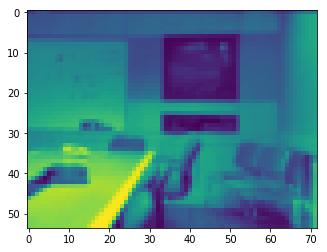

In [2]:
# Data import

x_train = []
x_test = []

for image_path in glob.glob("train_dataset/*.bmp"):
    image = misc.imread(image_path, mode = "L") # Reading in greyscale to speed up optimization
    image = misc.imresize(image, 0.45) # Resize image 
    image = image / 255 # Normalizing image 
    x_train.append(image)

for image_path in glob.glob("test_dataset/*.bmp"):
    image = misc.imread(image_path, mode = "L")
    image = misc.imresize(image, 0.45)
    image = image / 255
    x_test.append(image)

x_train = np.stack(x_train)
x_test = np.stack(x_test)

# Showing an example image 

plt.imshow(x_train[0]);
plt.show()

In [3]:
def wavelet_dec(sig, threshold=0.5):
    """
    Takes a signal as input, performs a single level Discrete Wavelet Transform of it and 
    sparsifies it with hard thresholding. Psi sparse basis in the article.
    
    Arguments:
    sig -- the signal to be sparsified (rows of the matrix Phi)
    threshold -- the data values where their absolute value is less than 
    the value param are replaced with substitute (default=0)
    
    Returns:
    sparse_sig -- signam expressed in a sparse haar wavelet basis 
    """
    
    coeffs = np.concatenate(dwt(sig, 'haar')) # concatenating the details and approximation coefficients 
    sparse_sig = pywt.threshold(coeffs, threshold, 'hard') # thresholding to sparsify
    
    return sparse_sig

def compressive_measurements(x, r, rand_type = "gauss"):
    """
    Takes an image and the compression rate as argument, returns a dictionnary
    
    Arguments:
    r -- compressive sample rate parameter (between 0 and 1), 
    the higher the closer to the original image
    x -- the original image
    rand_type -- type of random distribution for the measurement matrix
    
    Returns: 
    y -- vector of dimension (M (= r * N) x 1)
    A -- matrix of dimension (M x N), corresponds to Phi * Psi in the article
    x -- original image with shape (N x 1)
    dim_orig -- the original dimensions of the image
    """
    
    random.seed(10) # Setting seed for reproductibility
    
    nx, ny = x.shape
    N = nx * ny 
    M = round(N * r)
    x = x.reshape(1, -1).T # Reshape the image to be a (N x 1) vector
    
    if rand_type == "student":
        phi = np.random.standard_t(power, size=(M, N))
    else:
        phi = np.random.randn(M, N)        
        
    A = np.apply_along_axis(wavelet_dec, axis=1, arr=phi) # Equivalent to the Phi * Psi product
    
    y =  np.dot(A, x) # Compressive samples generation 
    
    cm = {"A": A, "y": y, "x": x, "dim_orig": (nx, ny)} 
    
    return cm
    
def signal_reconstruction(cm, lmbda1 = 0.1, lmbda2 = 8e-1):
    """
    Signal recovery using the Basis Pursuit Denoising (BPDN) and the L1
    Total Variation (TV) denoising algorithm from the SPORCO package
    
    Arguments:
    phi -- the measurement matrix of size (M x N)
    y -- the measurement vector of size (M x 1)
    lambda1 -- the hyperparameter controlling the L1 penalization for the BPDN algorithm
    lambda2 -- the hyperparameter controlling the L1 penalization for the TV algorithm
    
    Returns:
    x_hat -- the recovered signal from BPDN optimization (N x 1) 
    x_hat_rshp -- the reshaped recovered signal of size (nx x ny)
    imgr -- the denoised recovered signal of size (nx x ny)  

    """
    
    A, y = cm["A"], cm["y"]
    M = len(y)
    N = A.shape[1]
   
    # Run BPDN optimisation
    opt1 = bpdn.BPDN.Options()
    x = bpdn.BPDN(A, y, lmbda1, opt1)
    x_hat = x.solve()
    x_hat_rshp = x_hat.reshape(cm["dim_orig"])
    opt2 = tvl1.TVL1Denoise.Options()
        
    # Initialise and run TVL1Denoise object
    b1 = tvl1.TVL1Denoise(x_hat_rshp, lmbda2, opt2)
    x_hat_tv = b1.solve()
    
    return x_hat, x_hat_rshp, x_hat_tv

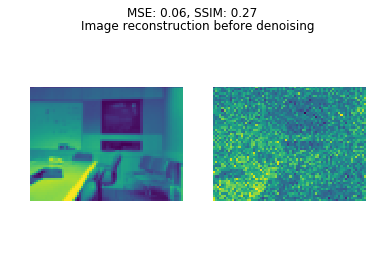

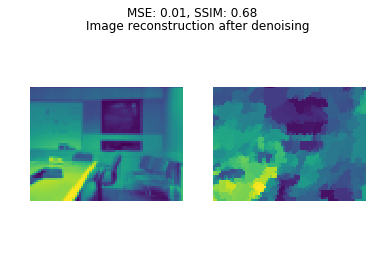

In [4]:
# Measurement of the performance of the optimizations algorithms

cm = compressive_measurements(x_train[0], 0.90)
x_hat, x_hat_rshp, x_hat_tv = signal_reconstruction(cm, lmbda1 = 0.1, lmbda2 = 8e-1)


def mse(imageA, imageB):
    """
    Returns the Mean Squared Error of two images pixelwise
    """
    
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    return err
 
def compare_images(imageA, imageB, title):
    """
    Compare two images using the MSE and the more advanced 
    skimage structural similarity index. 
    """
    m = mse(imageA, imageB) # between 0 and +infty (0 best)
    s = ssim(imageA, imageB) # between -1 and 1 (1 best)
 
    # setup the figure
    fig = plt.figure()
    plt.title(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    plt.axis("off")
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB)
    plt.axis("off")
 
    # show the images
    plt.show()

compare_images(x_train[0], x_hat_rshp, "Image reconstruction before denoising");
compare_images(x_train[0],x_hat_tv, "Image reconstruction after denoising");


# We observe that the recovery optimization algorithms perform well. The MSE is small for both
# images and the structural similarity index increases a lot after tv denoising